# Tree-based methods

Tree-based methods are quite popular in many domains using tabular data. In particular, Kaggle competitions tend to be won by teams making use of gradient-boosted methods like XGBoost and LightGBM. This notebook looks to explore these methods and see if they're useful in detecting fraud cases.

Additionally, the Isolation Forest method is considered as an anomaly detection method. The behavior of this method is a bit different than the others and requires a slightly different set up.

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import xgboost as xgb
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
class HourOfDayTransformer(BaseEstimator, TransformerMixin):
    """Transform time in seconds to hour of day
    
    Takes a time in seconds and transforms it into the hour of the day rounded down
    """
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        # take in dataframe and return transformed time
        # assert that column 'Time' exists
        if not 'Time' in x.columns:
            raise KeyError('Column "Time" not in DataFrame')
        
        x.loc[:, 'hour_of_day'] = x.Time.apply(lambda x: x // (60 * 60))
        day_2_idx = x.hour_of_day > 23.0
        x.loc[day_2_idx, 'hour_of_day'] = x.loc[day_2_idx, 'hour_of_day'].apply(lambda x: x - 24.0)
        x.drop('Time', axis=1, inplace=True)
        return x

In [3]:
class CorrelationTransformer(BaseEstimator, TransformerMixin):
    """Transform DataFrame based on correlation matrix
    
    Removes features that have low correlation with the target class.
    """
    def __init__(self, features=None, thresh=0.25):
        self.features_ = None
        self.thresh_ = thresh
    
    def fit(self, x, y):
        # calculate correlations with target from training data
        df = pd.DataFrame(x)
        df.loc[:, 'Class'] = y
        corrs = np.abs(df.corr().Class).sort_values(ascending=False)
        corrs = corrs.drop('Class')
        self.features_ = corrs[corrs > self.thresh_].index.tolist()
        return self
    
    def transform(self, x):
        # return reduced array
        return x[:, self.features_]

In [9]:
def plot_prc(clf, X, y):
    """Function to plot precision-recall curve
    
    Parameters:
    -----------
    clf : scikit-learn style classifier with predict_proba() method
    X : array-like, features used for prediction
    y : series-like, truth target values
    
    Returns:
    --------
    ap : float, average precision score
    """
    preds_proba = clf.predict_proba(X)
    ap = average_precision_score(y, preds_proba[:,1])
    precision, recall, thrs = precision_recall_curve(y, preds_proba[:,1])
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'AP score: {ap}')
    plt.show()
    return ap

In [5]:
df = pd.read_csv('data/creditcard.csv')

In [13]:
# create train and hold out sets
y = df.Class
X = df.drop('Class', axis=1)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [7]:
col_trans = ColumnTransformer(remainder='passthrough',
                              transformers=[('std', StandardScaler(), ['hour_of_day']),
                                            ('rob', RobustScaler(), ['Amount'])
                                           ]
                             )

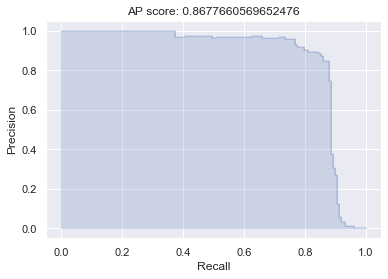

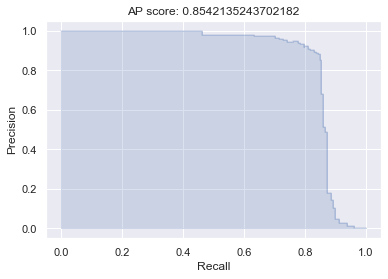

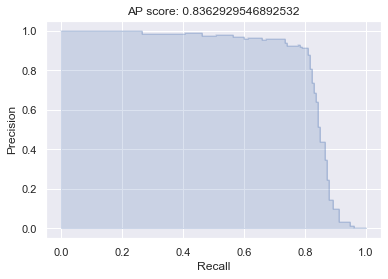

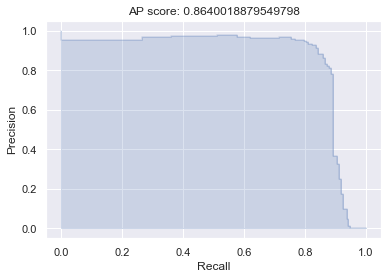

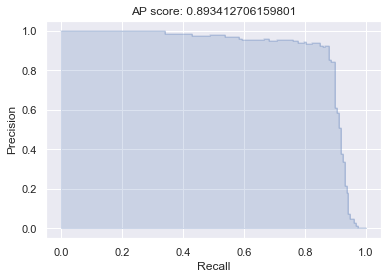

0.8631


In [17]:
# Start with a correlation threshold of 0.0
splits = 5
sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)
avg_ap = 0
for train_idx, val_idx in sss.split(X, y):
    imb_pipe = imb_make_pipeline(HourOfDayTransformer(),
                                 col_trans,
                                 SMOTE(sampling_strategy='minority'),
                                 CorrelationTransformer(thresh=0.00),
                                 RandomForestClassifier(n_estimators=100, n_jobs=4))
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()
    imb_pipe.fit(X_train, y_train)
    avg_ap += plot_prc(imb_pipe, X_val, y_val)
avg_ap /= splits
print(f'{avg_ap:.4f}')

In [21]:
preds = imb_pipe.predict(X_test.copy())
cm = confusion_matrix(y_test, preds)
print(cm)

[[56859     5]
 [   20    78]]


In [22]:
p = precision_score(y_test, preds)
r = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f'precision: {p}')
print(f'recall: {r}')
print(f'f1: {f1}')

precision: 0.9397590361445783
recall: 0.7959183673469388
f1: 0.8618784530386742


The random forest classifier does a good job with detecting fraud. Out of the fraud cases in the test set, the classifier detected 80% of them. Out of the predicted fraud cases, 93% were correctly classified thus keeping customers happy. Depending on the use case, the recall might still be too low and yield large losses due to the undetected fraud.

# XGBoost

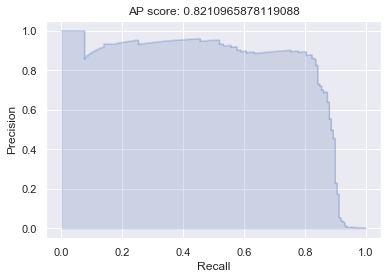

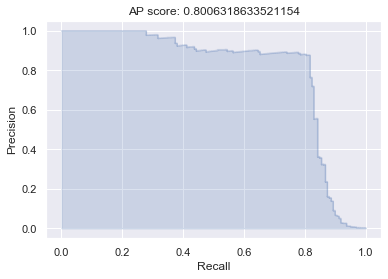

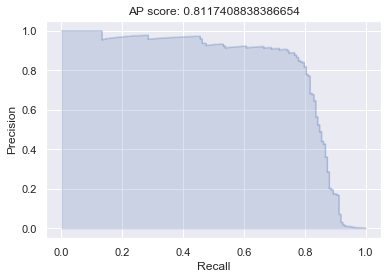

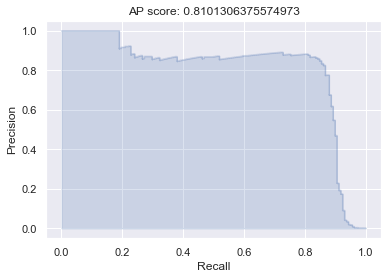

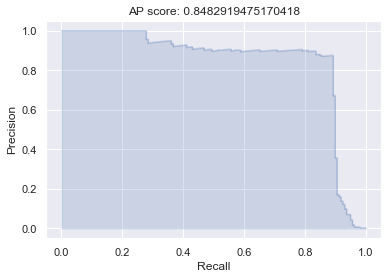

0.8184


In [27]:
# Try XGBoost classifier
splits = 5
sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)
avg_ap = 0
for train_idx, val_idx in sss.split(X, y):
    imb_pipe = imb_make_pipeline(HourOfDayTransformer(),
                                 col_trans,
                                 SMOTE(sampling_strategy='minority'),
                                 CorrelationTransformer(thresh=0.00),
                                 xgb.XGBClassifier(n_jobs=4))
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()
    imb_pipe.fit(X_train, y_train)
    avg_ap += plot_prc(imb_pipe, X_val, y_val)
avg_ap /= splits
print(f'{avg_ap:.4f}')

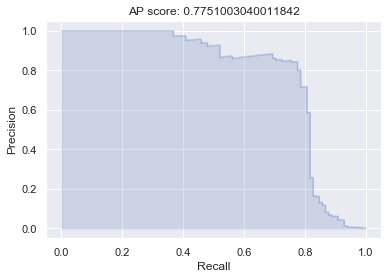

0.7751


In [28]:
# Check XGBoost performance on test hold out set
ap_test = plot_prc(imb_pipe, X_test.copy(), y_test.copy())
print(f'{ap_test:.4f}')

In [29]:
preds = imb_pipe.predict(X_test.copy())
cm = confusion_matrix(y_test, preds)
print(cm)

[[56114   750]
 [   13    85]]


In [30]:
p = precision_score(y_test, preds)
r = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f'precision: {p}')
print(f'recall: {r}')
print(f'f1: {f1}')

precision: 0.10179640718562874
recall: 0.8673469387755102
f1: 0.18220793140407288


The XGBoost classifier performs similarly to the random forest but it shows a bit more movement in the plateau region of the curves. On the test set the precision did not perform well while the recall did slightly better than the random forest. I would continue to use the random forest classifier over the XGBoost model.

# LightGBM

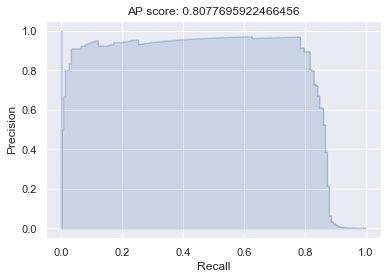

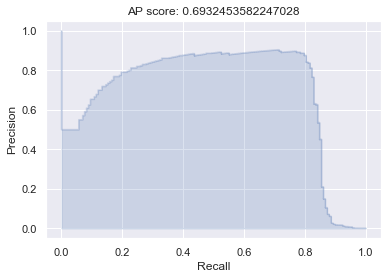

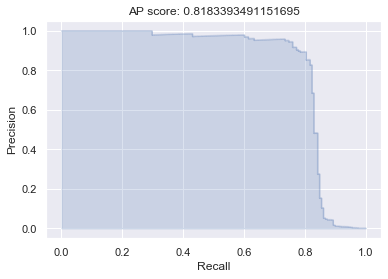

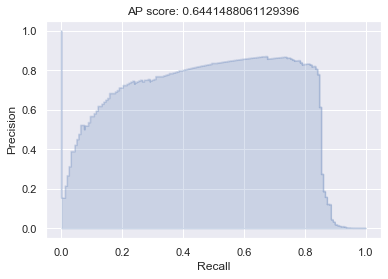

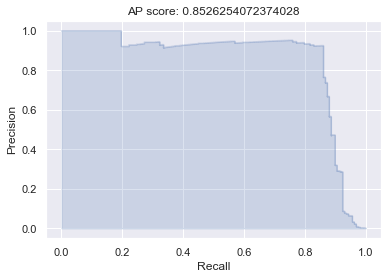

0.7632


In [31]:
# Try LightGBM classifier
splits = 5
sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)
avg_ap = 0
for train_idx, val_idx in sss.split(X, y):
    imb_pipe = imb_make_pipeline(HourOfDayTransformer(),
                                 col_trans,
                                 SMOTE(sampling_strategy='minority'),
                                 CorrelationTransformer(thresh=0.00),
                                 lgb.LGBMClassifier())
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()
    imb_pipe.fit(X_train, y_train)
    avg_ap += plot_prc(imb_pipe, X_val, y_val)
avg_ap /= splits
print(f'{avg_ap:.4f}')

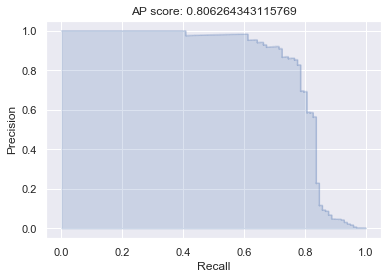

0.8063


In [32]:
# Check LightGBM performance on test hold out set
ap_test = plot_prc(imb_pipe, X_test.copy(), y_test.copy())
print(f'{ap_test:.4f}')

In [33]:
preds = imb_pipe.predict(X_test.copy())
cm = confusion_matrix(y_test, preds)
print(cm)

[[56829    35]
 [   19    79]]


In [34]:
p = precision_score(y_test, preds)
r = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f'precision: {p}')
print(f'recall: {r}')
print(f'f1: {f1}')

precision: 0.6929824561403509
recall: 0.8061224489795918
f1: 0.7452830188679246


The LightGBM classifier appears to have a wide range of performance depending on the training split. More work would need to be performed in order to have a reliable model in production.

# Isolation Forest

The purpose of the isolation forest is calculate the path length required to isolate a data point where the path length is the distance from the root node to the data point's leaf node. Anomalous events are expected to be easier to separate if they are "rare and different" thus leading to small path lengths. Some difficulties in anomaly detection include *masking*, where too many anomalies near each other conceal their presence, and *swamping*, where normal instances are identified as anomalies. To avoid this, it is actually beneficial to have an imbalanced data set.

The `predict` method returns `1` if the observation is an inlier and `-1` if not. `decision_function` gives the anomaly score. The lower, the more anomalous, with negative scores representing outliers and positive scores representing inliers. `score_samples` is the opposite of the anomlay score defined in the paper. The lower the more anomalous.

In order to compare the results of isolation forests with other tree-based methods, some alterations need to be made. The `decision_function` needs to be multiplied by -1.  Anything positive will be considered to be the positive case (fraud) and anything negative will be considered to be the non-fraud case. The `predict` method requires multiplication by -1 followed by setting any -1 instance with 0. Or more simply, leave `decision_function` and `predict` alone and instead multiply the truth target values by -1 and then set any 0 to 1. If the methods outputs are altered then the built-in metric functions will continue to work. If the truth targets are altered then the built-in metrics cannot be used.

In [37]:
def plot_prc_iso(clf, X, y):
    """Function to plot precision-recall curve
    
    Parameters:
    -----------
    clf : scikit-learn style classifier with predict_proba() method
    X : array-like, features used for prediction
    y : series-like, truth target values
    
    Returns:
    --------
    ap : float, average precision score
    """
    preds_proba = clf.decision_function(X)
    preds_proba *= -1
    ap = average_precision_score(y, preds_proba)
    precision, recall, thrs = precision_recall_curve(y, preds_proba)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'AP score: {ap}')
    plt.show()
    return ap

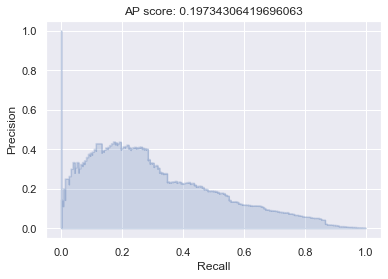

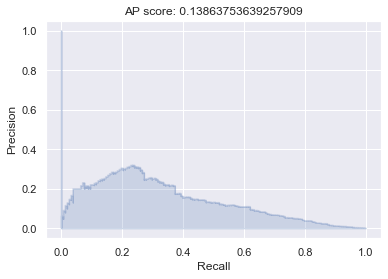

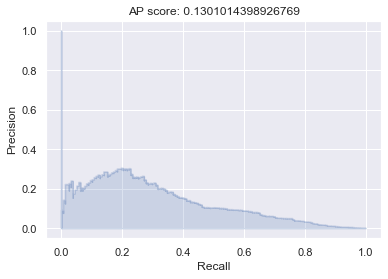

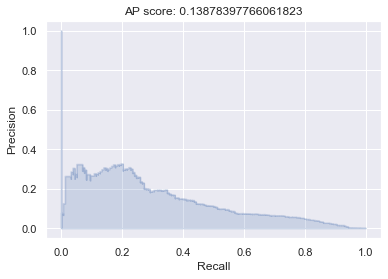

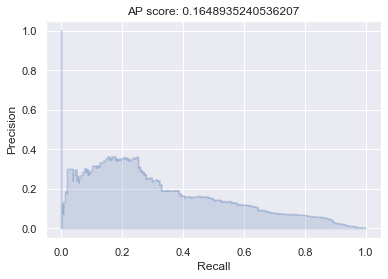

0.1540


In [53]:
# Try isolation forest classifier
# Paper recommends using 256 samples to train the tree to avoid swamping & masking effects
splits = 5
sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)
avg_ap = 0
for train_idx, val_idx in sss.split(X, y):
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()
    contamination = y_train.sum() / y_train.shape[0]
    iforest = IsolationForest(contamination=contamination,
                              behaviour='new',
                              n_jobs=5,
                              n_estimators=100,
                              max_samples=2**8)
    imb_pipe = imb_make_pipeline(HourOfDayTransformer(),
                                 col_trans,
                                 #SMOTE(sampling_strategy='minority'),
                                 CorrelationTransformer(thresh=0.00),
                                 iforest)
    imb_pipe.fit(X_train, y_train)
    avg_ap += plot_prc_iso(imb_pipe, X_val, y_val)
avg_ap /= splits
print(f'{avg_ap:.4f}')

In [51]:
preds_iso = imb_pipe.predict(X_test.copy())
preds_iso *= -1
preds_iso[preds_iso == -1] = 0
cm = confusion_matrix(y_test, preds_iso)
print(cm)

[[56791    73]
 [   74    24]]


In [52]:
p = precision_score(y_test, preds_iso)
r = recall_score(y_test, preds_iso)
f1 = f1_score(y_test, preds_iso)
print(f'precision: {p}')
print(f'recall: {r}')
print(f'f1: {f1}')

precision: 0.24742268041237114
recall: 0.24489795918367346
f1: 0.24615384615384617


It's not surprising to see the Isolation Forest algorithm perform poorly on this dataset. This algorithm is useful if the anomalies are either already rare and different, or if when sampling a small portion of the data causes the anomalies to be rare and different. As seen in the EDA notebook, fraud cases are close to each other and close to normal instances. The path length of fraud and non-fraud cases are going to be similar in this case.